### Importing utilities:

In [1]:
# %matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import skimage.external.tifffile as tiff

from common import Statistics, dataset_source
from resources.conv_learner import *
from resources.plots import *
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline

#### Setting up variables

In [3]:
PATH = "datasets/yeast_v11.1/"
data_path = Path(PATH)

In [4]:
CLASSES = ('WT', 'mfb1KO', 'mmr1KO', 'dnm1KO', 'LatA_5uM', 'fzo1KO', 'CK666')
NUM_CLASSES = len(CLASSES)
BATCH_SIZE = 64
SIZE = [2,224,224]

#### Calculating normalization statistics

Note that we are setting up train & val data, as well as test. Within test, we are here including a mutant cell type that the model never trains on. The idea is to use to the feature space developed during training to evaluate novel cell types by similarity to the landmarks that the model was trained on. 

In [5]:
classes = Statistics.source_class(data_path)

train_val = zip(classes['train'], classes['val'])
test_ = zip(classes['test'])


stats_name = "yeast_v11.1_per_class.dict"
main_stats = Statistics.per_class(train_val, save_name = stats_name)
test_stats = Statistics.per_class(test_)

working on: datasets\yeast_v11.1\train\02_mfb1KO
working on: datasets\yeast_v11.1\val\02_mfb1KO
working on: datasets\yeast_v11.1\train\02_mmr1KO
working on: datasets\yeast_v11.1\val\02_mmr1KO
working on: datasets\yeast_v11.1\train\02_WT
working on: datasets\yeast_v11.1\val\02_WT
working on: datasets\yeast_v11.1\train\03_CK666
working on: datasets\yeast_v11.1\val\03_CK666
working on: datasets\yeast_v11.1\train\03_dnm1KO
working on: datasets\yeast_v11.1\val\03_dnm1KO
working on: datasets\yeast_v11.1\train\03_fzo1KO
working on: datasets\yeast_v11.1\val\03_fzo1KO
working on: datasets\yeast_v11.1\train\03_LatA-5uM
working on: datasets\yeast_v11.1\val\03_LatA-5uM
working on: datasets\yeast_v11.1\train\03_WT
working on: datasets\yeast_v11.1\val\03_WT
working on: datasets\yeast_v11.1\train\04_WT
working on: datasets\yeast_v11.1\val\04_WT
working on: datasets\yeast_v11.1\test\01_mfb1KO
working on: datasets\yeast_v11.1\test\01_mmm1KO
working on: datasets\yeast_v11.1\test\01_mmr1KO
working on: da

In [ ]:
for keys in main_stats.keys():
    print(f"{keys}: \t \t \t {main_stats[keys]}")

In [ ]:
main_stats['02']

In [ ]:
for i in main_stats.keys():
    c0.append(main_stats[i][0][0]/main_stats[i][0][1])

In [78]:
for keys in test_stats.keys():
    print(f"{keys}: \t \t \t {test_stats[keys]}")

01_mfb1KO: 	 	 	 (array([0.0211 , 0.00454]), array([0.00151, 0.00165]))
01_mmm1KO: 	 	 	 (array([0.02102, 0.00424]), array([0.0015 , 0.00181]))
01_mmr1KO: 	 	 	 (array([0.02115, 0.00486]), array([0.00158, 0.00193]))
01_num1KO: 	 	 	 (array([0.02099, 0.00499]), array([0.00156, 0.00208]))
01_WT: 	 	 	 (array([0.0211 , 0.00449]), array([0.00149, 0.00129]))
02_mmr1KO-mfb1KO: 	 	 	 (array([0.00792, 0.00489]), array([0.00072, 0.00163]))
03_axl1KO: 	 	 	 (array([0.02547, 0.00477]), array([0.00224, 0.00144]))
03_bud1KO: 	 	 	 (array([0.02543, 0.00459]), array([0.00222, 0.00142]))
03_DTT: 	 	 	 (array([0.02585, 0.00495]), array([0.00225, 0.00166]))
03_Eth: 	 	 	 (array([0.02533, 0.00469]), array([0.00227, 0.00133]))
03_H2O2: 	 	 	 (array([0.02573, 0.00364]), array([0.00224, 0.00018]))
03_LatA-05uM: 	 	 	 (array([0.02535, 0.00497]), array([0.0025 , 0.00169]))


## Defining datasets:

In [6]:
def tfms_for_test(stats, sz):
    test_norm = Normalize(stats, IntNorm=True)
    test_denorm = Denormalize(stats)
    val_crop = CropType.NO
    test_tfms = image_gen(test_norm, test_denorm,sz, crop_type=val_crop)
    return test_tfms

In [13]:
def get_data(path: str, sz, bs): # , num_workers=1
    create, lbl2index, lbl2index_test = ImageClassifierData.prepare_from_path(path, val_name='val', bs=bs, num_workers = 8,
                                                                             test_name='test', test_with_labels=True, balance=True)

    main_stats_X = {lbl2index[key][0]: val for key, val in main_stats.items()}
    augs = [RandomDihedral(),
#             Random_brightness(),
#             RandomRotate(90),
#             Gauss_noise(stats = main_stats_X, IntNorm=True)
           ]
    tfms = tfms_from_stats_IntNorm(main_stats_X, sz, aug_tfms=augs, crop_type=CropType.CENTER, pad=sz[1]//8)
    
    test_stats_X = {lbl2index_test[key][0]: val for key, val in test_stats.items()}
    test_tfms = tfms_for_test(test_stats_X,sz)
    tfms += (test_tfms, )
    
    return create(tfms), lbl2index, lbl2index_test

In [14]:
data, lbl2idx, lbl2idx_test = get_data(PATH,SIZE,BATCH_SIZE)

In [15]:
x , y = next(iter(data.trn_dl))

In [ ]:
for i in range(20):
    print(np.mean(xs[i], axis=(1,2)))
#     print(np.std(xs[i], axis=(1,2)))
    


In [ ]:
to_np(x)[0].shape

In [ ]:
print(data.aug_dl.dataset.transform.tfms)

### Inspect loaded data:

Displaying the same image with and without normalization.

In [ ]:
# print transformations
plt.style.use('seaborn-white')

c = 1
idx = 0
fig, ax = plt.subplots(2,4, figsize=(16,10))
for i, ax in enumerate(ax.flat):
    x, y = next(iter(data.aug_dl))
    im = to_np(x)[idx]
#     ax.imshow(np.sum(im, axis = 0))
    ax.imshow(im[c])

In [ ]:
plt.style.use('seaborn-white')

In [ ]:
def load_epoch(dl = data.trn_dl):
    
    batch = iter(dl)

    xs = []
    ys = []

    for b in range(0,len(dl)):
        x_, y_ = next(batch)
        x_np, y_np = to_np(x_), to_np(y_)
        xs.append(x_np)
        ys.append(y_np)

    return np.vstack(xs), np.concatenate(ys)

In [ ]:
xs, ys =  load_epoch()

In [ ]:
def apply_tfm(ims, tfm_fn, **kwargs):
    
    tfmd_ims = np.zeros((ims.shape))
    
    for i in range(ims.shape[0]):
        tfmd_ims[i] = tfm_fn(ims[i,...], **kwargs)
        
    return tfmd_ims

In [ ]:
# xs_gauss = apply_tfm(xs, gauss_noiseX2, stats = [0.02515, 0.0025])
xs_bright = apply_tfm(xs, random_brightness)
# xs_gauss_bright = apply_tfm(xs_gauss, random_brightness)

In [ ]:
lbl2idx

In [ ]:
import seaborn as sns

In [ ]:
fig, axarr = plt.subplots(1, 2, figsize=(14, 8))

for i in [2,3]:
    
    xs_clss = xs[ys == i] 
    xs_sub = xs_clss[:100,...]
    xs_sub = xs_sub.reshape(-1,2,50176)
    
    ch0, ch1 = np.ravel(xs_sub[:,0]), np.ravel(xs_sub[:,1])
    print(ch1.shape)

    sns.kdeplot(ch0, ax = axarr[0], label = data.classes[i])
    sns.kdeplot(ch1, ax = axarr[1], label = data.classes[i])
    
axarr[0].set_xlim(-12,12);
axarr[1].set_xlim(-10,18);   
axarr[0].set_ylim(0,0.8);
axarr[1].set_ylim(0,1.8);
axarr[1].legend()

In [ ]:
fig, axarr = plt.subplots(1, 2, figsize=(14, 8))
colors = ['SteelBlue', 'Orange']
alphas = [1, 0.5]

for c,i in enumerate([2,3]):
    
    xs_clss = xs_bright[ys == i] 
    xs_sub = xs_clss[:20,...]
    xs_sub = xs_sub.reshape(-1,2,40000)
    col = colors[c]
    a = alphas[c]
    
    for im in range(20):
        ch0, ch1 = xs_sub[im,0], xs_sub[im,1]

        sns.kdeplot(ch0, ax = axarr[0], color = col, alpha = a)
        sns.kdeplot(ch1, ax = axarr[1], color = col, alpha = a)
        
axarr[0].set_xlim(-12,12);
axarr[1].set_xlim(-10,17);

In [ ]:
im.shape

In [ ]:
print(len(data.val_dl.dataset.y))
print(len(data.trn_dl.dataset.y))
print(len(data.test_dl.dataset.y))

# Training setup

In [ ]:
torch.cuda.is_available()

## ResNet_with_Batchnorm

Defining network architecture. 

In [16]:
# arch = resnet18_c
arch = resnet34_c

In [17]:
learn = ConvLearner.pretrained(arch, data, ps=0.25, opt_fn=optim.Adam, pretrained=False)

In [18]:
learn.unfreeze()

In [49]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 2, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', True),
                           ('nb_params', 6272)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', True),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 56

In [ ]:
learn.models.model

In [19]:
wd=1e-5 # weight-decay/L2 regularization 

In [24]:
learn.lr_find(1e-10)

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 37/39 [00:42<00:02,  1.15s/it, loss=7.73]

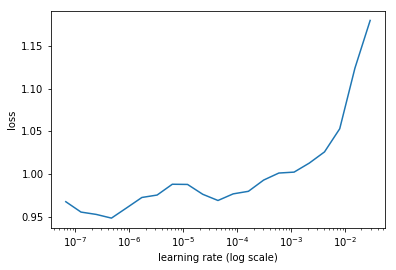

In [25]:
learn.sched.plot()

In [23]:
%time learn.fit(1e-3, 3, cycle_len=1, wds=wd, use_wd_sched=True)

EPOCH 0 ---------------------------------------- STEP 3                                                                                                                                                                                      
mean: [14.64103 13.41026 13.71795 13.79487 13.41026 13.89744 13.76923]
stdev: [6.14978 4.53882 3.90232 4.46169 3.50617 4.44796 4.2875 ]

[WT]: 8.571%
[mfb1KO]: 18.57%
[mmr1KO]: 68.57%
[CK666]: 8.571%
[LatA-5uM]: 24.29%
[dnm1KO]: 17.14%
[fzo1KO]: 95.71%
epoch      trn_loss   val_loss   accuracy   
    0      1.335382   1.99545    0.287302  
EPOCH 1 ---------------------------------------- STEP 4                                                                                                                                                                                      
mean: [13.05128 14.69231 13.4359  13.4359  14.10256 14.41026 13.58974]
stdev: [4.36741 4.72394 6.25441 4.40742 4.83998 3.93354 4.24698]

[WT]: 20.0%
[mfb1KO]: 78.57%
[mmr1KO]: 72.86%

[array([1.08089]), 0.5571428566698045]

In [ ]:
f = plt.figure()
x = learn.sched.plot_loss()
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.show()

In [ ]:
wd=1e-7 # weight-decay/L2 regularization 

In [27]:
%time learn.fit(1e-3, 3, cycle_len=2, cycle_mult=2, wds=wd, use_wd_sched=True)

EPOCH 0 ---------------------------------------- STEP 14                                                                                                                                                                                     
mean: [13.97436 13.79487 13.02564 14.33333 12.71795 14.5641  14.28205]
stdev: [4.24558 4.27383 4.68214 4.12828 3.90232 4.98611 3.94155]

[WT]: 42.86%
[mfb1KO]: 88.57%
[mmr1KO]: 84.29%
[CK666]: 82.86%
[LatA-5uM]: 37.14%
[dnm1KO]: 78.57%
[fzo1KO]: 85.71%
epoch      trn_loss   val_loss   accuracy   
    0      0.739069   0.866098   0.650794  
EPOCH 1 ---------------------------------------- STEP 15                                                                                                                                                                                     
mean: [14.07692 14.      13.38462 13.89744 14.23077 13.79487 13.38462]
stdev: [4.27506 3.92885 4.40638 3.58626 4.83821 4.42707 3.59212]

[WT]: 45.71%
[mfb1KO]: 90.0%
[mmr1KO]: 84.29%

[array([0.62296]), 0.7301587304425619]

In [29]:
%time learn.fit(1e-4, 2, cycle_len=4, wds=wd, use_wd_sched=True)

EPOCH 0 ---------------------------------------- STEP 28                                                                                                                                                                                     
mean: [12.82051 14.94872 14.05128 13.51282 14.64103 14.17949 12.41026]
stdev: [4.24791 4.50042 5.13384 5.1683  4.56007 3.88205 4.85015]

[WT]: 32.38%
[mfb1KO]: 95.71%
[mmr1KO]: 72.86%
[CK666]: 58.57%
[LatA-5uM]: 78.57%
[dnm1KO]: 100.0%
[fzo1KO]: 100.0%
epoch      trn_loss   val_loss   accuracy   
    0      0.373277   0.770744   0.669841  
EPOCH 1 ---------------------------------------- STEP 29                                                                                                                                                                                     
mean: [13.30769 14.51282 14.17949 14.25641 14.23077 13.5641  12.4359 ]
stdev: [4.68579 5.13346 4.17484 3.51348 4.12908 5.75925 4.75985]

[WT]: 61.43%
[mfb1KO]: 94.29%
[mmr1KO]: 84.29

[array([0.54573]), 0.7714285718070136]

In [33]:
%time learn.fit(5e-4, 2, cycle_len=8, wds=wd, use_wd_sched=True)

EPOCH 0 ---------------------------------------- STEP 36                                                                                                                                                                                     
mean: [13.38462 14.33333 12.25641 14.82051 12.76923 14.38462 14.53846]
stdev: [4.21606 4.32247 3.98534 3.52916 4.44604 4.04218 5.71927]

[WT]: 12.86%
[mfb1KO]: 70.0%
[mmr1KO]: 30.0%
[CK666]: 34.29%
[LatA-5uM]: 61.43%
[dnm1KO]: 100.0%
[fzo1KO]: 92.86%
epoch      trn_loss   val_loss   accuracy   
    0      0.335459   1.886915   0.474603  
EPOCH 1 ---------------------------------------- STEP 37                                                                                                                                                                                     
mean: [14.61538 13.94872 13.87179 13.35897 13.25641 14.66667 12.84615]
stdev: [4.53259 3.78898 4.14592 4.25162 4.46478 5.06032 4.22774]

[WT]: 79.05%
[mfb1KO]: 94.29%
[mmr1KO]: 72.86%


EPOCH 15 ---------------------------------------- STEP 51                                                                                                                                                                                    
mean: [15.15385 13.25641 14.61538 13.41026 13.94872 12.53846 13.58974]
stdev: [5.38058 4.11201 4.83372 4.6998  4.03795 5.56014 5.49927]

[WT]: 66.19%
[mfb1KO]: 97.14%
[mmr1KO]: 84.29%
[CK666]: 74.29%
[LatA-5uM]: 84.29%
[dnm1KO]: 100.0%
[fzo1KO]: 97.14%
    15     0.248281   0.428436   0.81746   
Wall time: 13min 16s


[array([0.42844]), 0.8174603150004432]

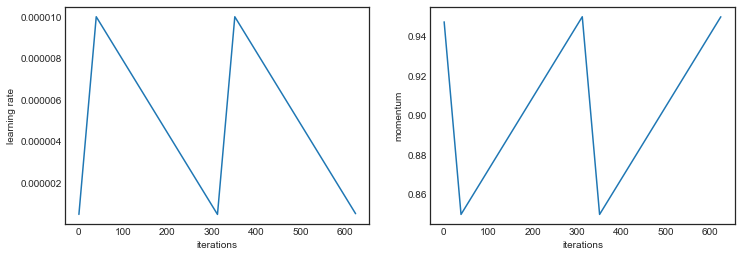

In [38]:
learn.sched.plot_lr()

#### Run some more cylces - error & accuracy should continuously improve

Note: cycle len = number of epochs per cycle

In [37]:
%time learn.fit(1e-5, 2, cycle_len=8, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85))

EPOCH 0 ---------------------------------------- STEP 68                                                                                                                                                                                     
mean: [14.58974 14.25641 13.28205 13.10256 14.30769 13.87179 13.30769]
stdev: [4.24094 5.0976  4.99717 5.16296 5.32124 4.01395 4.63074]

[WT]: 70.48%
[mfb1KO]: 97.14%
[mmr1KO]: 85.71%
[CK666]: 70.0%
[LatA-5uM]: 87.14%
[dnm1KO]: 98.57%
[fzo1KO]: 98.57%
epoch      trn_loss   val_loss   accuracy   
    0      0.202535   0.398796   0.831746  
EPOCH 1 ---------------------------------------- STEP 69                                                                                                                                                                                     
mean: [12.82051 14.4359  13.89744 13.53846 13.74359 14.53846 13.74359]
stdev: [4.22369 5.24182 4.41904 4.36093 4.62833 4.02458 4.3484 ]

[WT]: 72.86%
[mfb1KO]: 97.14%
[mmr1KO]: 85.71%

EPOCH 15 ---------------------------------------- STEP 83                                                                                                                                                                                    
mean: [14.12821 12.53846 13.53846 14.07692 13.07692 15.23077 14.05128]
stdev: [4.24373 4.27183 4.55646 4.0849  4.80056 4.04755 4.59626]

[WT]: 68.1%
[mfb1KO]: 97.14%
[mmr1KO]: 85.71%
[CK666]: 72.86%
[LatA-5uM]: 91.43%
[dnm1KO]: 100.0%
[fzo1KO]: 98.57%
    15     0.189202   0.416811   0.833333  
Wall time: 11min 35s


[array([0.41681]), 0.83333333276567]

In [ ]:
%time learn.fit(5e-5, 1, cycle_len=8, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85))

In [ ]:
%time learn.fit(5e-7, 1, cycle_len=4, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85))

In [60]:
print(lbl2idx)

{'02_WT': [0, 0, 'WT'], '02_mfb1KO': [1, 1, 'mfb1KO'], '02_mmr1KO': [2, 2, 'mmr1KO'], '03_CK666': [3, 3, 'CK666'], '03_LatA-5uM': [4, 4, 'LatA-5uM'], '03_WT': [5, 0, 'WT'], '03_dnm1KO': [6, 5, 'dnm1KO'], '03_fzo1KO': [7, 6, 'fzo1KO'], '04_WT': [8, 0, 'WT']}


In [59]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 2, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 6272)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 

In [ ]:
learn.models.model

In [58]:
learn.freeze_to(2)

In [68]:
adjust = {0:22,
          1:16,
          2:22,
#           3:20,
#           4:20,
         5:16,
         6:16}
# use_clr=(20,8, 0.95, 0.85),
%time learn.fit(1e-5, 1, cycle_len=4, wds=wd, use_wd_sched=True, adjust_class=adjust)

  0%|                                                                                                                                                                                                                 | 0/39 [00:00<?, ?it/s][731 181 277 414 201 373 267]
EPOCH 0 ---------------------------------------- STEP 115                                                                                                                                                                                    
mean: [20.79487 15.87179 22.20513  3.38462  4.02564 15.25641 15.41026]
stdev: [3.70848 3.77019 4.10865 2.84303 4.22136 4.25904 4.56136]

[WT]: 82.38%
[mfb1KO]: 95.71%
[mmr1KO]: 80.0%
[CK666]: 45.71%
[LatA-5uM]: 84.29%
[dnm1KO]: 98.57%
[fzo1KO]: 98.57%
epoch      trn_loss   val_loss   accuracy   
    0      0.112056   0.414184   0.833333  
  0%|                                                                                                                                                     

[array([0.41059]), 0.8428571443709116]

## Analysis/Model evaluation

This is one of the major areas that needs improvement in our workflow. The tools we have so far (confusion matrix and manual inpsection of images) are essential but definitely not sufficient to ensure that our model learns something biologicaly relevant. Ideas are welcome!

### ...after training 

In [66]:
learn.save('YNet_v11.1_ResNet34_dihedral_ps025_IntNorm_FT-nonActin_84')

In [ ]:
## Load model:
learn.load('YNet_v11.1_ResNet18_dihedral_89')

In [ ]:
learn.freeze()

In [ ]:
%time learn.fit(1e-3, 1, cycle_len=1, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85))

In [ ]:
learn.lr_find()

In [69]:
log_preds, y = learn.TTA(n_aug=1) # run predictions with TTA

### Cross_validation evaluation

[[180   3   8  30   4   0   0]
 [  4  65   0   0   0   0   1]
 [  2   1  57   0   1   0   0]
 [ 16   0   4  35   4   0   0]
 [  7   0   1   5  61   0   0]
 [  0   0   0   0   0  70   0]
 [  1   1   0   0   0   0  69]]


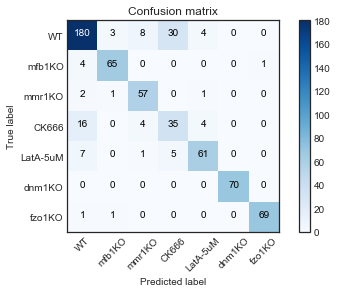

In [70]:
# Plot confusion matrix 
plt.style.use('seaborn-white')
log_preds_mean = np.mean(log_preds, axis=0)
preds = np.argmax(log_preds_mean, axis=1)
cm = confusion_matrix(preds,y)
plot_confusion_matrix(cm, data.classes)

## Test-set eval

In [ ]:
learn.models.model

In [71]:
# function to be called by register_forward_hook

def get_embeddings(layer_name):
    def register_hook(layer_name):
        def get_embedding(layer, inp, outp):
            tmp = inp[0]
            embedding.append(tmp)

        hook = layer.register_forward_hook(get_embedding) 
        
        for i in ['trn', 'val', 'test']:
            embedding = []
            preds, y = learn.predict_with_targs(i)
            
            # populating dict, consiting of [0]: preds, [1]: y, [2]: activations[layer]
            embeddings[i] = [preds, y, np.vstack(to_np(embedding))]
            
        hook.remove()
        
    embeddings = {}    
    layer = learn.models.model._modules.get(layer_name)
    register_hook(layer)
    
    return embeddings

In [72]:
embeddings = get_embeddings('14')

In [73]:
# unpacking embeddings

embs_trn = embeddings['trn'][2]
y_trn = embeddings['trn'][1]

embs_val = embeddings['val'][2]
y_val = embeddings['val'][1]

embs_test = embeddings['test'][2]
y_test = embeddings['test'][1]

print(embs_trn.shape)
print(embs_val.shape)
print(embs_test.shape)

print(y_trn.shape)
print(y_val.shape)
print(y_test.shape)


(2444, 512)
(630, 512)
(2721, 512)
(2444,)
(630,)
(2721,)


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
# running PCA on embeddings
pca = []
n_components = 50
pca = PCA(n_components)

trn_pca_result = pca.fit_transform(embs_trn)
val_pca_result = pca.transform(embs_val)
test_pca_result = pca.transform(embs_test)

In [ ]:
#plotting compenent-wise cumulative explained variance (for PCA)

plt.plot(range(n_components), pca.explained_variance_ratio_)
plt.plot(range(n_components), np.cumsum(pca.explained_variance_ratio_))
plt.title("Component-wise and Cumulative Explained Variance")

In [ ]:
# running TSNE on embeddings

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(embs_trn)

In [ ]:
# plotting PCA vs TSNE results

fig, axarr = plt.subplots(1, 2, figsize=(20, 8))

compA = 0
compB = 1

for i in range(7):
    PCA_cls = trn_pca_result[y_trn == i]
    TSNE_cls = tsne_results[y_trn == i]
    
    axarr[0].scatter(PCA_cls[:,compA], PCA_cls[:,compB], label = data.classes[i])
    axarr[1].scatter(TSNE_cls[:,compA], TSNE_cls[:,compB], label = data.classes[i])
    axarr[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
# plotting PCA vs TSNE results

fig, axarr = plt.subplots(1, 2, figsize=(20, 8))

compA = 0
compB = 1

for i in range(7):
    trn_PCA_cls = trn_pca_result[y_trn == i]
    val_PCA_cls = val_pca_result[y_val == i]

    axarr[0].scatter(trn_PCA_cls[:,compA], trn_PCA_cls[:,compB], label = data.classes[i])
    axarr[1].scatter(val_PCA_cls[:,compA], val_PCA_cls[:,compB], label = data.classes[i])
    axarr[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
print(lbl2idx_test)

In [ ]:
# plotting PCA vs TSNE results

fig, axarr = plt.subplots(1, 2, figsize=(20, 8))

compA = 0
compB = 1

for i in range(7):
    trn_PCA_cls = trn_pca_result[y_trn == i]

    axarr[0].scatter(trn_PCA_cls[:,compA], trn_PCA_cls[:,compB], label = data.classes[i])
    axarr[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axarr[0].set_xlim(-15,45)
    axarr[0].set_ylim(-20,20)
    
for i in [0,1,3]:
    test_PCA_cls = test_pca_result[y_test == i]
    axarr[1].scatter(test_PCA_cls[:,compA], test_PCA_cls[:,compB], label = list(lbl2idx_test.keys())[i])
    axarr[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axarr[1].set_xlim(-15,45)
    axarr[1].set_ylim(-20,20)


In [ ]:
list(lbl2idx_test.keys())[0]

In [ ]:
# Generate 3D TSNE space from PCA of embeddings

tsne3D = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300, learning_rate=50.0)
PCA2tSNE_results_3D = tsne3D.fit_transform(embs)

In [ ]:
tsne3D

In [ ]:
from mpl_toolkits import mplot3d

# magic command to make plots interactive.
# restart kernel if you want to switch to e.g. %matplotlib inline
%matplotlib notebook

In [ ]:
# 3D plotting - very slow interactivity atm...

fig = plt.figure()
ax = plt.axes(projection='3d')

compA = 0
compB = 1
compC = 2

for i in range(10):
    clss = PCA2tSNE_results_3D[y == i]
    cls_C = clss[0:500,:]
    ax.scatter3D(cls_C[:,compA], cls_C[:,compB], cls_C[:,compC])

In [45]:
import umap

In [74]:
UMAP_trn_embedding = umap.UMAP(n_neighbors=10,
                      min_dist=0.3,
                      metric='correlation').fit(embs_trn)

UMAP_trn = UMAP_trn_embedding.embedding_
UMAP_val = UMAP_trn_embedding.transform(embs_val)
UMAP_test = UMAP_trn_embedding.transform(embs_test)

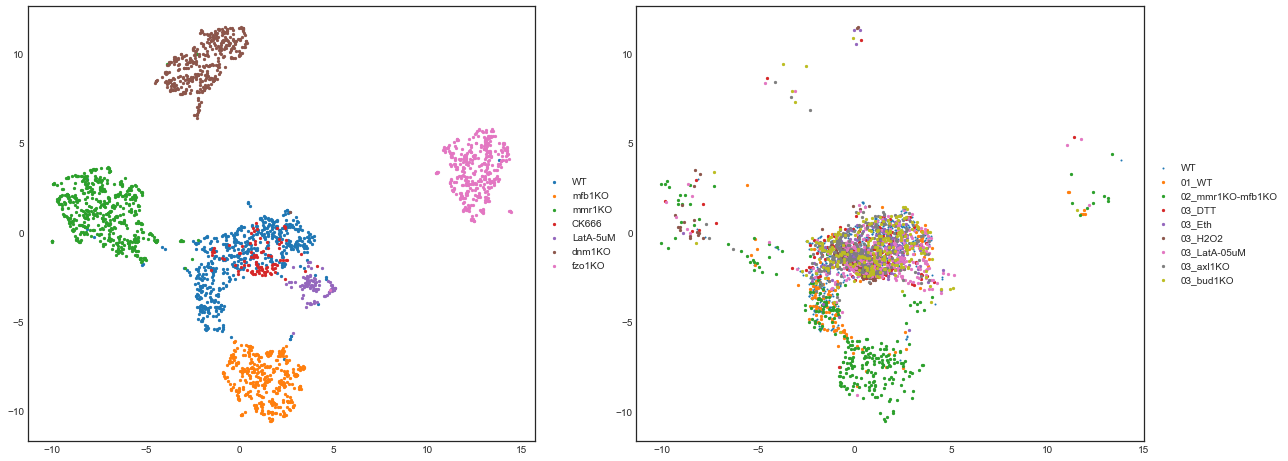

In [76]:
# plotting PCA vs TSNE results

fig, axarr = plt.subplots(1, 2, figsize=(20, 8))

compA = 0
compB = 1

for i in range(7):
    trn_UMAP_cls = UMAP_trn[y_trn == i]

    axarr[0].scatter(trn_UMAP_cls[:,compA], trn_UMAP_cls[:,compB], label = data.classes[i], s = 5)
    axarr[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    if i == 0:
        axarr[1].scatter(trn_UMAP_cls[:,compA], trn_UMAP_cls[:,compB], label = data.classes[i], s = 1)

#     axarr[0].set_xlim(-22,15)
#     axarr[0].set_ylim(-15,12)
    
for i in [0,5,6,7,8,9,10,11]:
    test_UMAP_cls = UMAP_test[y_test == i]
    
    axarr[1].scatter(test_UMAP_cls[:,compA], test_UMAP_cls[:,compB], label = list(lbl2idx_test.keys())[i], s = 5)
    axarr[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     axarr[1].set_xlim(-22,15)
#     axarr[1].set_ylim(-15,12)


In [ ]:
print(lbl2idx_test)

### Visualizing train and test datasets as exposed by dataloader

## @Yinan, please take the functionality of the next 2 cells and transfer it to the data_vis.py

In [ ]:
dl_ = data.trn_dl
batch_ = iter(dl_)


plt.style.use('seaborn-white')
fig = plt.figure()
ax = plt.subplot(111)

for b in range(0,len(dl_)):
    x_, y_ = next(batch_)

    x_np = to_np(x_)
    y_np = to_np(y_)
    
    im_means = np.mean(x_np, axis=(2,3))
    
    ax.plot(im_means[:,0], im_means[:,1], 'o', color = 'C0' , alpha=0.5)
        
plt.xlim(-0.4,0.4)
plt.ylim(-1, 4)

In [ ]:
dl_t = data.test_dl
batch_t = iter(dl_t)

plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = plt.subplot(111)

for b in range(0,len(dl_t)):
    x_, y_ = next(batch_t)

    x_np = to_np(x_)
    y_np = to_np(y_)
    
    im_means = np.mean(x_np, axis=(2,3))
    
    ax.plot(im_means[:,0], im_means[:,1], 'o', color = 'C1' , alpha=0.5)
    
plt.xlim(-0.4,0.4)
plt.ylim(-1, 4)

### Inference

In [81]:
test_log_preds, targs = learn.predict_with_targs('test')
testprobs = np.exp(test_log_preds)
preds = np.argmax(testprobs, axis=1)

## @James, please transfer the functionality of the next 5 cells into the data_vis.py

In [ ]:
# @James, there is definitely a simpler way of generating test_lbl2idx_ than calling this entire line. Please trim it down. 

_, lbl2idx_, test_lbl2idx_ = ImageClassifierData.prepare_from_path(PATH, val_name='val', bs=64, num_workers=1, test_name='test', test_with_labels=True)


In [79]:
lbl2idx_test

{'01_WT': [0, 0, 'WT'],
 '01_mfb1KO': [1, 1, 'mfb1KO'],
 '01_mmm1KO': [2, 2, 'mmm1KO'],
 '01_mmr1KO': [3, 3, 'mmr1KO'],
 '01_num1KO': [4, 4, 'num1KO'],
 '02_mmr1KO-mfb1KO': [5, 5, 'mmr1KO-mfb1KO'],
 '03_DTT': [6, 6, 'DTT'],
 '03_Eth': [7, 7, 'Eth'],
 '03_H2O2': [8, 8, 'H2O2'],
 '03_LatA-05uM': [9, 9, 'LatA-05uM'],
 '03_axl1KO': [10, 10, 'axl1KO'],
 '03_bud1KO': [11, 11, 'bud1KO']}

In [82]:
# make predictions dictionary

h = 0
preds_dict = {}
for i, key in enumerate(lbl2idx_test.keys()):
    l = h
    h = h + list(data.test_dl.dataset.src_idx).count(i)
    preds_dict[key] = list(preds[l:h])
    print(f"{key} predictions ready ({h - l} elements)")

01_WT predictions ready (140 elements)
01_mfb1KO predictions ready (140 elements)
01_mmm1KO predictions ready (195 elements)
01_mmr1KO predictions ready (205 elements)
01_num1KO predictions ready (75 elements)
02_mmr1KO-mfb1KO predictions ready (284 elements)
03_DTT predictions ready (258 elements)
03_Eth predictions ready (260 elements)
03_H2O2 predictions ready (310 elements)
03_LatA-05uM predictions ready (309 elements)
03_axl1KO predictions ready (290 elements)
03_bud1KO predictions ready (255 elements)


In [83]:
preds_rel = {}
for key in preds_dict.keys():
    print(key)
    val = {cls: preds_dict[key].count(i)/len(preds_dict[key]) for i, cls in enumerate(data.classes)}
    preds_rel[key]= val

01_WT
01_mfb1KO
01_mmm1KO
01_mmr1KO
01_num1KO
02_mmr1KO-mfb1KO
03_DTT
03_Eth
03_H2O2
03_LatA-05uM
03_axl1KO
03_bud1KO


In [84]:
def plot_test_preds(targets, preds_rel):
    
    if not isinstance(targets, list):
        targets = [targets]
        
    x = math.ceil((int(len(targets)) /2)) # dynamic scaling of GridSpec
    sz = 4 * x # dynamic scaling of figuresize
    
    # plotting:
    plt.figure(figsize=(12,sz))
    gs1 = plt.GridSpec(x,2)
    gs1.update(wspace = 0.4)

    for i, targ in enumerate(targets):
        to_plot = [preds_rel[targ][key] for key in data.classes] # extracting data
        ax1 = plt.subplot(gs1[i])
        ax1.barh(data.classes, to_plot)
        ax1.set_title(targ)
        ax1.set_xlim(0,1)
    
    plt.show()

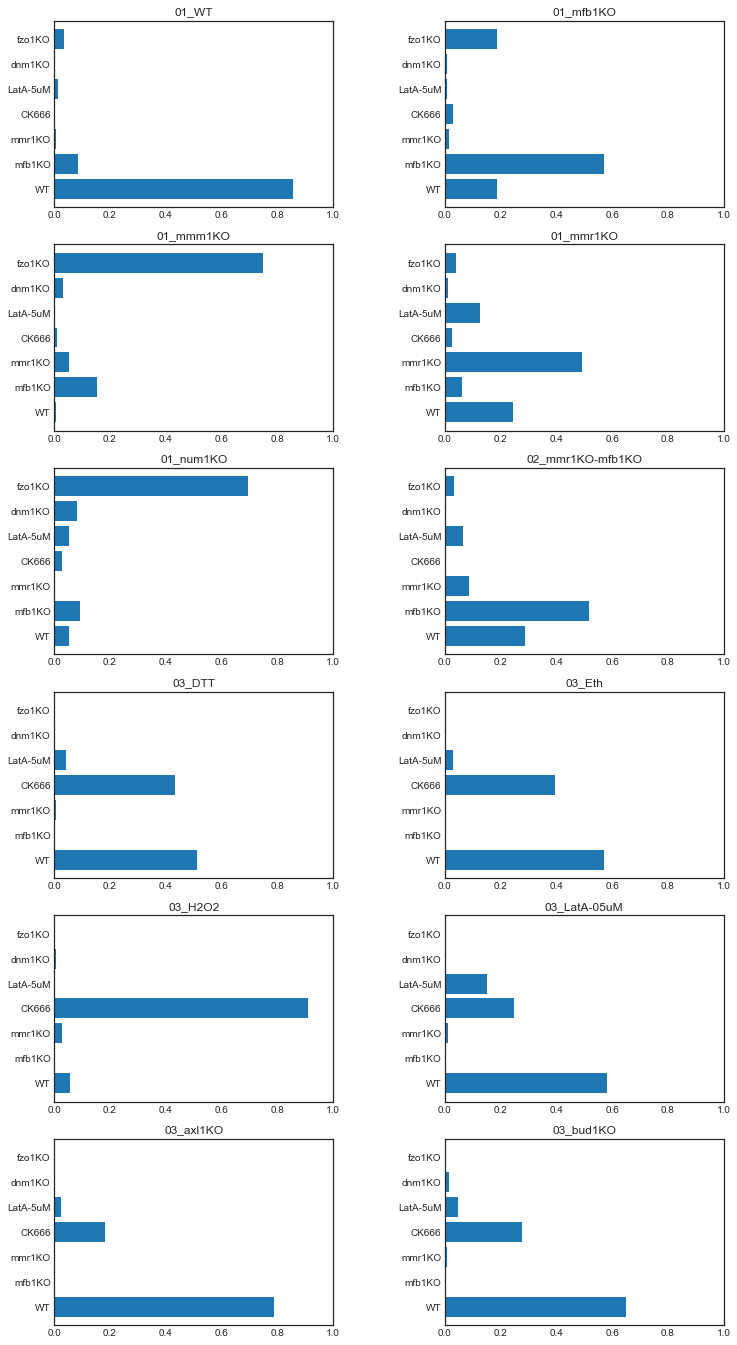

In [87]:
test_classes = list(lbl2idx_test.keys())

plot_test_preds(test_classes, preds_rel)
# plot_test_preds(['01_WT', '03_WT', '03_fzo1KO', '01_mfb1KO'], preds_rel)
# plot_test_preds(['01_WT', '01_mfb1KO', '01_mmr1KO'], preds_rel)

### Analyse images 

#### Show random correct/incorrectly classified images:

In [ ]:
log_preds_mean = np.mean(log_preds, axis=0) # averages predictions on original + 4 TTA images
preds = np.argmax(log_preds_mean, axis=1) # converts into 0 or 1

In [ ]:
# probs = np.exp(log_preds_mean[:,0]) # prediction(WT)
probs = np.exp(log_preds_mean) # predictions

In [ ]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [ ]:
def plots(ims, channel, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=11)
        if channel is not None: plt.imshow(ims[i,channel,:,:]) 
        else: plt.imshow(np.sum(ims, axis=1)[i,:,:])

In [ ]:
def plot_val_with_title_from_ds_no_denorm(idxs, title, channel=None):
    
    imgs = np.stack(data.val_ds[x][0] for x in idxs) # get images by idx
    corr_lbl = np.stack(data.val_ds[x][1] for x in idxs) # get correct label from data.val_ds by idx
    pred_lbl = np.stack(preds[x] for x in idxs) # get predicted label from preds by idx
    p_max = [np.amax(probs[x,:]) for x in idxs] # get highest probability from probs by idx
    
    title_fin = [f"true = {corr_lbl[x]}\n predicted: {pred_lbl[x]}\n  p = {p_max[x]}" for x, _ in enumerate(corr_lbl)]
    print(title)
    
    return plots(imgs, channel, rows=1, titles=title_fin, figsize=(16,8))

In [ ]:
lbl2idx_

### Plot images according to predictions

In [ ]:
# load from ds - not denormalized! 
plot_val_with_title_from_ds_no_denorm(rand_by_correct(True), "Correctly classified")
#optionally pass channel arg. to select single channel

In [ ]:
plot_val_with_title_from_ds_no_denorm(rand_by_correct(False), "Incorrectly classified")

#### Show most correct/incorrectly classified images per class:

In [ ]:
def most_by_mask(mask, y, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[:,y][idxs])[0:5]]

def most_by_correct(y, is_correct): 
    mult = -1 if is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), y, mult)

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(0, True), "Most correctly classified WT")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(0, False), "Most incorrectly classified WT") # logic?

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(1, True), "Most correctly classified mfb1KO") 

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(1, False), "Most incorrectly classified mfb1KO")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(2, True), "Most correctly classified mfb1KO-mmr1KO")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(3, True), "Most correctly classified CK666")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(4, True), "Most correctly classified LatA")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(5, True), "Most correctly classified dnnm1KO")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(6, True), "Most correctly classified fzo1KO")

#### Show (most) uncertain images

In [ ]:
most_uncertain = t = np.argsort(np.amax(probs, axis = 1))[1:5] # get best "guess" per image and list the least confident ones
plot_val_with_title_from_ds_no_denorm(most_uncertain, "Most uncertain predictions")

In [ ]:
lbl2idx_